## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
import math
pylab.rcParams['figure.figsize'] = (8.25, 6)

Importing and formatting the training data

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set_no_zeros.csv")

In [3]:
# Seperating variables
# The outcomes
tornado_outcome = tor_df.iloc[:, [0]]


# Make sure variable is right
list(tornado_outcome)

['DAMAGE_PROPERTY']

In [4]:
# The predictors
tornado_predictors = tor_df.iloc[:, 1:]


# Make sure the variables are right
list(tornado_predictors)

['DURATION_SECONDS',
 'BEGIN_LAT',
 'BEGIN_LON',
 'TOR_LENGTH',
 'TOR_WIDTH',
 'YEAR',
 'MULTI_VORT_IND',
 'OPEN_WATER_PROP',
 'DEV_OPEN_PROP',
 'DEV_LOW_PROP',
 'DEV_MED_PROP',
 'DEV_HIGH_PROP',
 'BARREN_LAND_PROP',
 'DECID_FOREST_PROP',
 'EVERGR_FOREST_PROP',
 'MIXED_FOREST_PROP',
 'SHRUB_SCRUB_PROP',
 'GRASS_LAND_PROP',
 'PASTURE_HAY_PROP',
 'CULT_CROPS_PROP',
 'WOOD_WETLAND_PROP',
 'HERB_WETLAND_PROP',
 'INCOME',
 'MOB_HOME_DENS',
 'POP_DENS',
 'TOR_AREA',
 'TOT_DEV_INT',
 'TOT_WOOD_AREA',
 'WOOD_DEV_INT',
 'EXP_INC_AREA',
 'DAY_OF_YEAR',
 'MONTH',
 'STATE_RANK',
 'TIME']

In [5]:
# Make the outcomes into a numpy array
outcome_array = tornado_outcome.values

# Makes that numpy array into a torch Tensor
outcome_Tensor = torch.from_numpy(outcome_array)


# Make the predictors into a numpy array
predictors_array = tornado_predictors.values

# Make that numpy array into a torch Tensor
predictors_Tensor = torch.from_numpy(predictors_array)


# Convert those DoubleTensors to FloatTensors
# Changing outcomes from a DoubleTensor to a FloatTensor
outcome_Tensor = outcome_Tensor.float()

# Changing predictors too
predictors_Tensor = predictors_Tensor.float()

Now the cross-validation data

In [6]:
# Import cross-validation data
cv_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set_no_zeros.csv")


# Get the outcomes
cv_outcome = cv_df.iloc[:, [0]]

# Convert the pandas column to a ndarray and then into a FloatTensor
cv_outcome_Tensor = torch.from_numpy(cv_outcome.values).float()


# Make sure the variable is right
list(cv_outcome)

['DAMAGE_PROPERTY']

In [7]:
# Get the validation set predictors
cv_predictors = cv_df.iloc[:, 1:]

# Make the validation set predictors into a numpy array
cv_predictors_Tensor = torch.from_numpy(cv_predictors.values).float()


# Make sure the variables are right
list(cv_predictors)

['DURATION_SECONDS',
 'BEGIN_LAT',
 'BEGIN_LON',
 'TOR_LENGTH',
 'TOR_WIDTH',
 'YEAR',
 'MULTI_VORT_IND',
 'OPEN_WATER_PROP',
 'DEV_OPEN_PROP',
 'DEV_LOW_PROP',
 'DEV_MED_PROP',
 'DEV_HIGH_PROP',
 'BARREN_LAND_PROP',
 'DECID_FOREST_PROP',
 'EVERGR_FOREST_PROP',
 'MIXED_FOREST_PROP',
 'SHRUB_SCRUB_PROP',
 'GRASS_LAND_PROP',
 'PASTURE_HAY_PROP',
 'CULT_CROPS_PROP',
 'WOOD_WETLAND_PROP',
 'HERB_WETLAND_PROP',
 'INCOME',
 'MOB_HOME_DENS',
 'POP_DENS',
 'TOR_AREA',
 'TOT_DEV_INT',
 'TOT_WOOD_AREA',
 'WOOD_DEV_INT',
 'EXP_INC_AREA',
 'DAY_OF_YEAR',
 'MONTH',
 'STATE_RANK',
 'TIME']

Now the test set data

In [8]:
# Import the test set data
test_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_test_set_no_zeros.csv")


# Get the outcomes
test_outcome = test_df.iloc[:, [0]]

# Convert the pandas column to a ndarray and then into a FloatTensor
test_outcome_Tensor = torch.from_numpy(test_outcome.values).float()


# Make sure the variable is right
list(test_outcome)

['DAMAGE_PROPERTY']

In [9]:
# Get the test set predictors
test_predictors = test_df.iloc[:, 1:]

# Make the test set predictors into a numpy array
test_predictors_Tensor = torch.from_numpy(test_predictors.values).float()


# Make sure the variables are right
list(test_predictors)

['DURATION_SECONDS',
 'BEGIN_LAT',
 'BEGIN_LON',
 'TOR_LENGTH',
 'TOR_WIDTH',
 'YEAR',
 'MULTI_VORT_IND',
 'OPEN_WATER_PROP',
 'DEV_OPEN_PROP',
 'DEV_LOW_PROP',
 'DEV_MED_PROP',
 'DEV_HIGH_PROP',
 'BARREN_LAND_PROP',
 'DECID_FOREST_PROP',
 'EVERGR_FOREST_PROP',
 'MIXED_FOREST_PROP',
 'SHRUB_SCRUB_PROP',
 'GRASS_LAND_PROP',
 'PASTURE_HAY_PROP',
 'CULT_CROPS_PROP',
 'WOOD_WETLAND_PROP',
 'HERB_WETLAND_PROP',
 'INCOME',
 'MOB_HOME_DENS',
 'POP_DENS',
 'TOR_AREA',
 'TOT_DEV_INT',
 'TOT_WOOD_AREA',
 'WOOD_DEV_INT',
 'EXP_INC_AREA',
 'DAY_OF_YEAR',
 'MONTH',
 'STATE_RANK',
 'TIME']

## 1. Two Hidden Layers, 100 Neurons Each, 75% Dropout

Define the model architecture

In [10]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 100)
        self.fc2 = torch.nn.Linear(100, 100)
        self.fc3 = torch.nn.Linear(100, 1)
        
    def forward(self, x):
        x = torch.nn.functional.dropout(x, p = 0.75)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, p = 0.75)
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.dropout(x, p = 0.75)
        x = self.fc3(x)
        return(x)


# Make it
model = Net()

Define the loss function

In [11]:
loss_fn = torch.nn.MSELoss(size_average = False)

Defining a function to setup and train the models. It will also produce a loss versus iteration plot

In [12]:
def train_neural_net(model, train_outcomes, train_inputs,
                     cv_outcomes, cv_inputs):
    
    # This function will train the neural network and produce a loss versus iteration plot
    # model = the model architecture, a Net class
    # train_outcomes = the right answers, PyTorch Tensor
    # train_inputs = what we're using to get to the right answers, PyTorch Tensor
    # cv_outcomes = the right answers of the new data, PyTorch Tensor
    # cv_inputs = what we're using to get the new right answers, PyTorch Tensor
    # Returns a plot and a trained Net
    
    
    # Make the outcomes into a Torch Variable
    outcome_Variable = Variable(train_outcomes)
    
    # Make the cv outcomes into a Torch Variable
    cv_outcome_Variable = Variable(cv_outcomes,
                                   requires_grad = False)
    
    # Make the predictors into a Torch Variable
    predictors_Variable = Variable(train_inputs,
                                   requires_grad = False)
    
    # Make the cv predictors into a Torch Variable
    cv_predictors_Variable = Variable(cv_inputs,
                                      requires_grad = False)
    
    
    # Make an empty list to add to for each iteration
    current_loss_value_mini = []
    
    # For the cv too
    current_cv_loss_value = []
    
    
    # Set the optimizer
    optimizer = torch.optim.Adagrad(model.parameters(), lr = 1e-2)
    
    
    # Train the neural network
    for t in range(20000):
        
        # Get the current mini-batch indices
        indices = torch.randperm(len(predictors_Tensor))[0:50]
        
        # Get the current mini-batches
        predictors_mini = predictors_Variable[indices]
        outcome_mini = outcome_Variable[indices]
        
        # Get the current predictions
        current_pred_mini = model(predictors_mini)
        cv_pred = model(cv_predictors_Variable)
        
        # Compute current losses and and append that to the empty list
        current_loss_mini = loss_fn(current_pred_mini, outcome_mini)
        current_loss_value_mini.append(current_loss_mini.data[0])
        
        current_cv_loss = loss_fn(cv_pred, cv_outcome_Variable)
        current_cv_loss_value.append(current_cv_loss.data[0])
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss_mini.backward()
        
        # Update model parameters
        optimizer.step()
    
    
    # Get iterations as a list for x-axis of plot
    iterations = list(range(0, 20000))
    
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value_mini) / len(predictors_mini)).tolist()
    
    # For cv too
    mse_cv = (np.asarray(current_cv_loss_value) / len(cv_predictors_Variable)).tolist()
    
    
    # Plot loss versus iteration
    plt.plot(iterations, mse)
    plt.plot(iterations, mse_cv, "r-")
    plt.xlabel("Iteration", size = 14)
    plt.ylabel("Loss Value", size = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("How'd the Optimizing Go?", size = 16)

Train the first model.

The plot will display how well it optimized. The blue line is the mini batch values that the model was optimized on, while the red line is new (cross-validation) data.

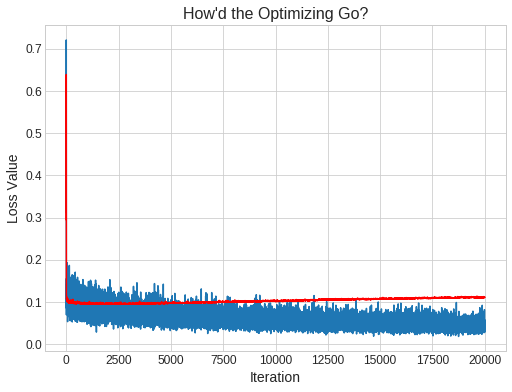

In [13]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

How'd the model perform on the data used to make it?

In [14]:
def plot_train_perf(train_predictors, train_obs):
    
    # Plots how well the model performs on training data
    # train_predictors = the values that the model predicts from, PyTorch Tensor
    # train_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Get the predictions
    train_predictions = model(Variable(train_predictors, requires_grad = False))
    
    # Convert that to a numpy array
    train_predictions = train_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    train_predictions = (train_predictions*5.407597 + 7.688844).tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    train_obs = (train_obs.numpy()*5.407597 + 7.688844).tolist()
    
    
    # Plot it
    plt.scatter(train_obs, train_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    axes.set_xlim([-1, 24])
    axes.set_ylim([-1, 24])
    axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)
    axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_title("Model Performance on Training Data", size = 16)

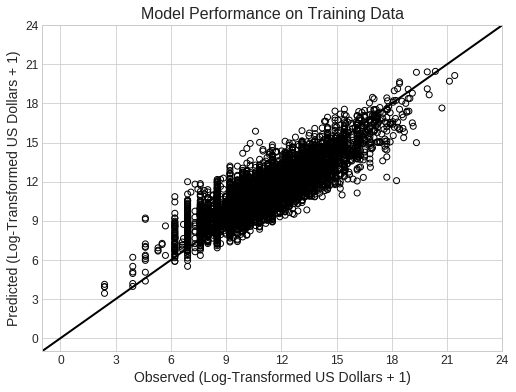

In [15]:
plot_train_perf(predictors_Tensor, outcome_Tensor)

### 1.1 Performance Metrics

We're really interested in how it does on new data, so let's get some metrics of its performance on the new data.

First: Mean squared error (MSE)

In [16]:
def compute_MSE(predictors, observed_outcomes):
    
    # Computes the mean squared error of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield
    # Returns a PyTorch Variable
    
    
    # Get the validation set predictions
    cv_predictions = model(Variable(predictors, requires_grad = False))
    
    # Get the validation set outcomes
    cv_outcomes = Variable(observed_outcomes)
    
    
    # Get the loss - (total) residual sum of squares
    total_SE = loss_fn(cv_predictions, cv_outcomes)
    
    # Average that to get mean square error
    mean_SE = total_SE / len(predictors)
    return(mean_SE)

In [17]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)

Second: MSE for observed values over 1 million dollars

In [18]:
def compute_MSE_over_1mil(predictors, observed_outcomes):
    
    # Computes the mean squared error on observed values of over 1 million dollars
    # predictors = the variables and values used in prediction, PyTorch Tensor
    # observed_outcomes = what the prediction would ideally yield, PyTorch Tensor
    # Returns a PyTorch Variable
    
    
    # Getting the model-ready equivalent of 1 million
    one_million = (np.log(1e6 + 1) - 7.688844) / 5.407597
    
    # Combining predictions and observations into a DataFrame
    df = pd.DataFrame(model(Variable(predictors)).data.numpy())
    df.columns = ['predicted']
    df['observed'] = observed_outcomes.numpy()
    
    # Only keeping rows which contain observed values greater than 1 million dollars
    df = df.loc[df['observed'] >= one_million]
    
    # Making those columns model-ready
    predicted = Variable(torch.from_numpy(np.asarray(df['predicted'])))
    observed = Variable(torch.from_numpy(np.asarray(df['observed'])))
    
    # Get the MSE
    total_SE = loss_fn(predicted, observed)
    mean_SE = total_SE / len(df['observed'])
    return(mean_SE)

In [19]:
MSE_over_1mil = compute_MSE_over_1mil(cv_predictors_Tensor, cv_outcome_Tensor)

Third: R<sup>2</sup> (R-squared)

In [20]:
def compute_R_squared(predictors, observed_outcomes):
    
    # Computes R-squared of the model
    # predictors = the variables and values used in prediction, PyTorch Tensor
    # observed_outcomes = what the prediction would ideally yield, PyTorch Tensor
    # Returns a PyTorch Variable
    
    
    # Get the mean of the observed outcomes
    observed_mean = (sum(observed_outcomes) / len(observed_outcomes)).numpy()[0]
    
    # Fill an ndarray with that
    valid_outcomes_mean = np.repeat(observed_mean, len(observed_outcomes))
    
    # Convert that to a Variable
    valid_outcomes_mean = Variable(torch.from_numpy(valid_outcomes_mean))
    
    
    # Compute total sum of squares
    TSS = loss_fn(valid_outcomes_mean, Variable(observed_outcomes))
    
    
    # Compute residual sum of squares
    RSS = loss_fn(model(Variable(predictors)), Variable(observed_outcomes))
    
    
    # Compute R-squared
    R_squared = 1 - (RSS / TSS)
    return(R_squared)

In [21]:
R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)

How many parameters did it take to achieve that?

#### WARNING: NON-ROBUST CALCULATION

Make sure that for each '(n + 1)', n = number of neurons in a hidden layer

In [22]:
Number_of_Parameters = ((34 + 1) * 100) + ((100 + 1) * 100) + ((100 + 1) * 1)

#### Save these metrics

In [23]:
def save_metrics(Num_of_param, r_squared, mean_square_error, mse_over_1mil, notebook_id, model_id):
    
    # Saves the number of parameters, R-squared, MSE, MSE on observations over 1 million,
    #    along with a notebook and model identifier
    # The following inputs are PyTorch Variables: r_squared, mean_square_error, and mse_over_1mil
    # The following inputs are numbers: Num_of_param, notebook_id, model_id
    # Returns this as a DataFrame
    
    
    # Make the DataFrame, starting with the Number of Parameters as a sole column
    df = pd.DataFrame([Num_of_param])
    
    # Rename the column
    df.columns = ['Number of Parameters']
    
    
    # Add on R-squared and rename the column
    r_squared = r_squared.data.numpy().tolist()
    df['R-squared'] = r_squared
    
    # Add on MSE and rename the column
    mean_square_error = mean_square_error.data.numpy().tolist()
    df['Mean Squared Error'] = mean_square_error
    
    # Add on MSE on observations over 1 million and rename the column
    mse_over_1mil = MSE_over_1mil.data.numpy().tolist()
    df['Mean Squared Error Over 1M'] = mse_over_1mil
    
    # Add the notebook and model identifier
    df['notebook_id'] = [notebook_id]
    df['model_id'] = [model_id]
    return(df)

In [24]:
metrics_df = save_metrics(Number_of_Parameters, R_squared, MSE, MSE_over_1mil, 20, 1)
metrics_df

,Number of Parameters,R-squared,Mean Squared Error,Mean Squared Error Over 1M,notebook_id,model_id
0,13701,0.343789,0.111094,0.199585,20,1


### 1.2 Performance Visualization

In log-transformed space, plot predicted values versus observed values for new data

In [25]:
def plot_cross_valid_perf(cv_predictors, cv_obs):
    
    # Plots how well the model performs on new data
    # cv_pred = the values that the model predicts from, PyTorch Tensor
    # cv_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Convert to a PyTorch Variable and get the predictions
    cv_predictions = model(Variable(cv_predictors, requires_grad = False))
    
    # Convert that to a numpy array
    cv_predictions = cv_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    cv_predictions = (cv_predictions*5.407597 + 7.688844).tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    cv_obs = (cv_obs.numpy()*5.407597 + 7.688844).tolist()
    
    
    # Plot it
    plt.scatter(cv_obs, cv_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    axes.set_xlim([-1, 24])
    axes.set_ylim([-1, 24])
    axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)
    axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)")
    axes.set_title("Model Performance on Cross-Validation Data", size = 16)
    plt.text(0.5, 22, r"$R^2$ = %s"%(R_squared.data.numpy()[0]), size = 12)
    plt.text(0.5, 20, "MSE = %s"%(MSE.data.numpy()[0]), size = 12)
    plt.text(0.5, 18, "MSE over 1M = %s"%(MSE_over_1mil.data.numpy()[0]), size = 12)

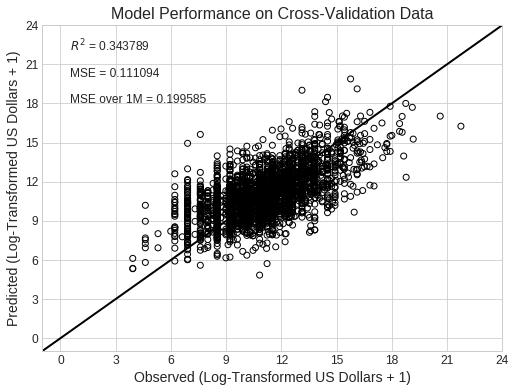

In [26]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

Lastly, let's inspect the first hidden layer's weights

In [27]:
model.fc1.weight

Parameter containing:
-0.1716  0.0985 -0.0175  ...  -0.1008  0.0622  0.1085
 0.0353  0.0399  0.0071  ...  -0.1026  0.0848 -0.0821
 0.1559 -0.1070  0.1400  ...  -0.0020 -0.1263  0.0647
          ...             ⋱             ...          
-0.0939  0.0549 -0.1166  ...  -0.2057  0.0108  0.1973
 0.1694  0.0028 -0.0731  ...   0.1245 -0.1161  0.0286
 0.1098 -0.1633 -0.1392  ...  -0.0258 -0.1211  0.1937
[torch.FloatTensor of size 100x34]

### 1.3 Store Predictions

In [28]:
def convert_pred_to_df(predictors_to_use, notebook_id, model_id, dataset):
    
    # Saves the model predictions as a DataFrame, pairs these predictions with a
    #    notebook identifier, model identifier, the dataset (cv or test), and
    #    the corresponding true values (observations)
    # The following inputs are numbers: notebook_id, model_id
    # dataset = either 'cv' or 'test'
    # predictors_to_use = a PyTorch Tensor
    # Returns a DataFrame
    
    
    # Convert the Tensor into a Variable and predict off of it
    model_pred = model(Variable(predictors_to_use))
    
    # Convert that Variable into a list
    model_pred = model_pred.data.numpy().tolist()
    
    # Convert that list into a DataFrame
    model_pred = pd.DataFrame(model_pred)
    
    # Give the column an appropriate name
    model_pred.columns = ["predicted_values"]
    
    
    # Add notebook identifier as a column
    model_pred["notebook_number"] = pd.Series(np.repeat(notebook_id,
                                                        len(model_pred["predicted_values"])))
    
    # Add model identifier as a column
    model_pred["model_number"] = pd.Series(np.repeat(model_id,
                                                     len(model_pred["predicted_values"])))
    
    # Add the data set as a column
    model_pred["data_set"] = pd.Series(np.repeat(dataset,
                                                 len(model_pred["predicted_values"])))
    
    # Add the observed values as a column
    model_pred["true_values"] = pd.DataFrame(outcome_Tensor.numpy().tolist())
    return(model_pred)

In [29]:
stored_cv_pred_df = convert_pred_to_df(cv_predictors_Tensor, 20, 1, 'cv')

stored_test_pred_df = convert_pred_to_df(test_predictors_Tensor, 20, 1, 'test')

## 2. 60% Dropout

In [30]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 100)
        self.fc2 = torch.nn.Linear(100, 100)
        self.fc3 = torch.nn.Linear(100, 1)
        
    def forward(self, x):
        x = torch.nn.functional.dropout(x, p = 0.60)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, p = 0.60)
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.dropout(x, p = 0.60)
        x = self.fc3(x)
        return(x)


# Make it
model = Net()

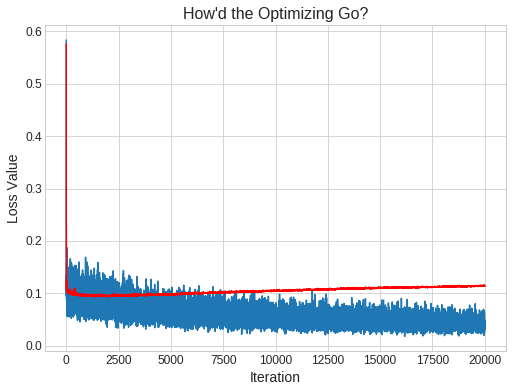

In [31]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

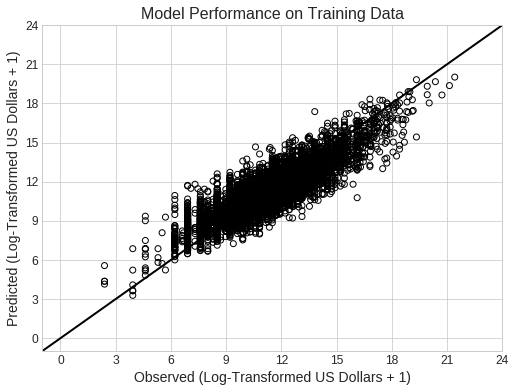

In [32]:
plot_train_perf(predictors_Tensor, outcome_Tensor)

### 2.1 Performance Metrics

In [33]:
# Compute the metrics
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)

MSE_over_1mil = compute_MSE_over_1mil(cv_predictors_Tensor, cv_outcome_Tensor)

R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)


# Save the metrics in a temporary DataFrame
temp_df = save_metrics(Number_of_Parameters, R_squared, MSE, MSE_over_1mil, 20, 2)

# Append that temporary DataFrame onto the existing one
metrics_df = metrics_df.append(temp_df, ignore_index = True)

### 2.2 Performance Visualization

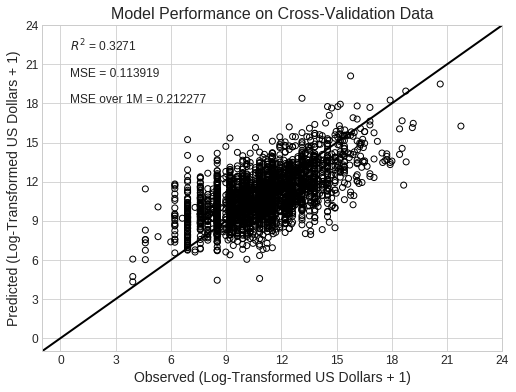

In [34]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [35]:
model.fc1.weight

Parameter containing:
 0.1109  0.2003 -0.0607  ...   0.1335 -0.2117 -0.1147
 0.0538  0.1106 -0.0808  ...   0.1767 -0.0185 -0.2247
-0.0456 -0.0913 -0.1829  ...  -0.1653 -0.0512  0.0236
          ...             ⋱             ...          
 0.0448 -0.0201 -0.1016  ...   0.1437  0.0352  0.0571
-0.0569 -0.0127 -0.1479  ...  -0.1577  0.1450  0.0120
-0.0060  0.0969  0.0708  ...   0.0035 -0.2097  0.1042
[torch.FloatTensor of size 100x34]

### 2.3 Store Predictions

In [36]:
# Using temporary DataFrames to append the new predictions onto the existing predictions DataFrame
temp_df = convert_pred_to_df(cv_predictors_Tensor, 20, 2, 'cv')
stored_cv_pred_df = stored_cv_pred_df.append(temp_df, ignore_index = True)

temp_df = convert_pred_to_df(test_predictors_Tensor, 20, 2, 'test')
stored_test_pred_df = stored_test_pred_df.append(temp_df, ignore_index = True)

## 3. 35% Dropout

In [37]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 100)
        self.fc2 = torch.nn.Linear(100, 100)
        self.fc3 = torch.nn.Linear(100, 1)
        
    def forward(self, x):
        x = torch.nn.functional.dropout(x, p = 0.35)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, p = 0.35)
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.dropout(x, p = 0.35)
        x = self.fc3(x)
        return(x)


# Make it
model = Net()

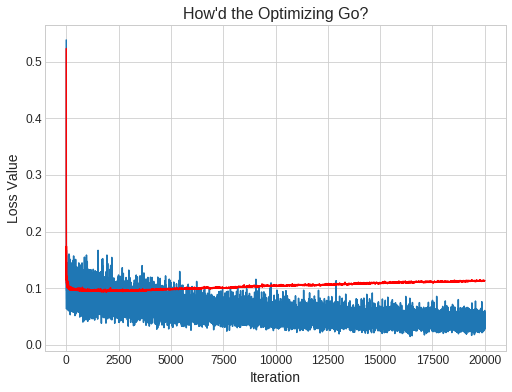

In [38]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

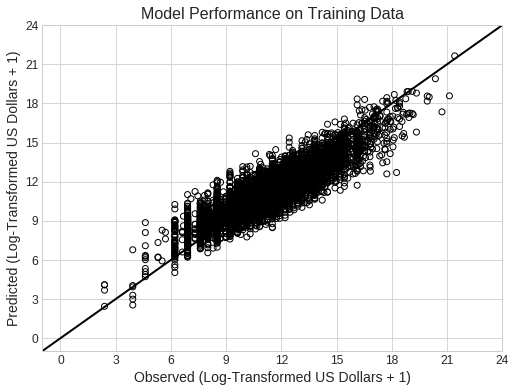

In [39]:
plot_train_perf(predictors_Tensor, outcome_Tensor)

### 3.1 Performance Metrics

In [40]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)

MSE_over_1mil = compute_MSE_over_1mil(cv_predictors_Tensor, cv_outcome_Tensor)

R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)

temp_df = save_metrics(Number_of_Parameters, R_squared, MSE, MSE_over_1mil, 20, 3)
metrics_df = metrics_df.append(temp_df, ignore_index = True)

### 3.2 Performance Visualization

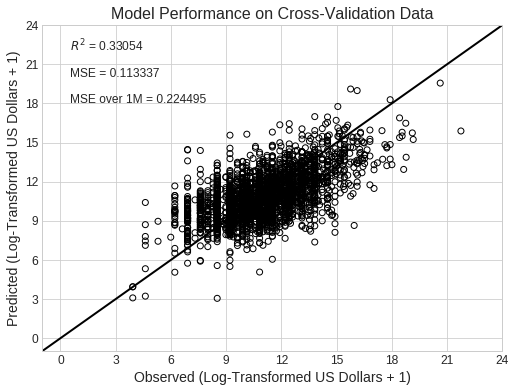

In [41]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [42]:
model.fc1.weight

Parameter containing:
-0.0427 -0.2084 -0.0947  ...   0.1446  0.0756 -0.1261
-0.1084 -0.1732  0.0310  ...   0.0557  0.2154  0.0227
-0.0257  0.1243 -0.0331  ...  -0.2162  0.0917  0.2781
          ...             ⋱             ...          
-0.0527  0.0244 -0.1710  ...   0.0971  0.0853  0.1466
-0.1961  0.0219 -0.1775  ...  -0.2389  0.1275 -0.0909
-0.1280  0.0161  0.0208  ...   0.1294 -0.0209 -0.1964
[torch.FloatTensor of size 100x34]

### 3.3 Store Predictions

In [43]:
temp_df = convert_pred_to_df(cv_predictors_Tensor, 20, 3, 'cv')
stored_cv_pred_df = stored_cv_pred_df.append(temp_df, ignore_index = True)

temp_df = convert_pred_to_df(test_predictors_Tensor, 20, 3, 'test')
stored_test_pred_df = stored_test_pred_df.append(temp_df, ignore_index = True)

## 4. 20% Dropout

In [44]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 100)
        self.fc2 = torch.nn.Linear(100, 100)
        self.fc3 = torch.nn.Linear(100, 1)
        
    def forward(self, x):
        x = torch.nn.functional.dropout(x, p = 0.20)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, p = 0.20)
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.dropout(x, p = 0.20)
        x = self.fc3(x)
        return(x)


# Make it
model = Net()

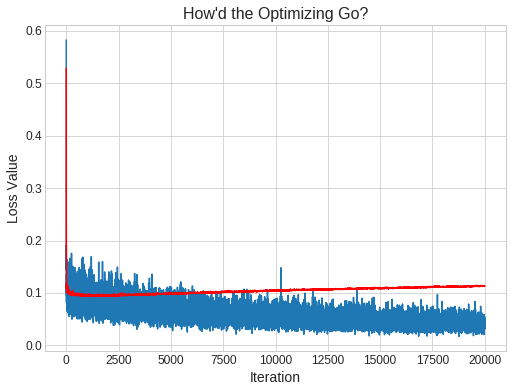

In [45]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

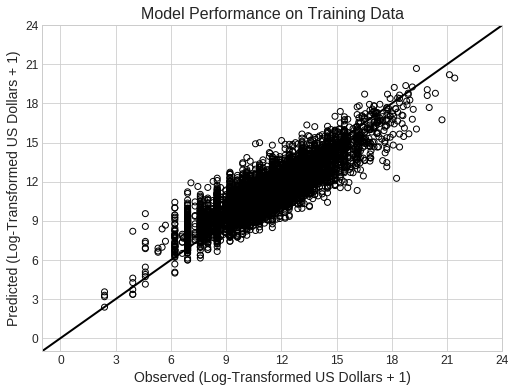

In [46]:
plot_train_perf(predictors_Tensor, outcome_Tensor)

### 4.1 Performance Metrics

In [47]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)

MSE_over_1mil = compute_MSE_over_1mil(cv_predictors_Tensor, cv_outcome_Tensor)

R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)

temp_df = save_metrics(Number_of_Parameters, R_squared, MSE, MSE_over_1mil, 20, 4)
metrics_df = metrics_df.append(temp_df, ignore_index = True)

### 4.2 Performance Visualization

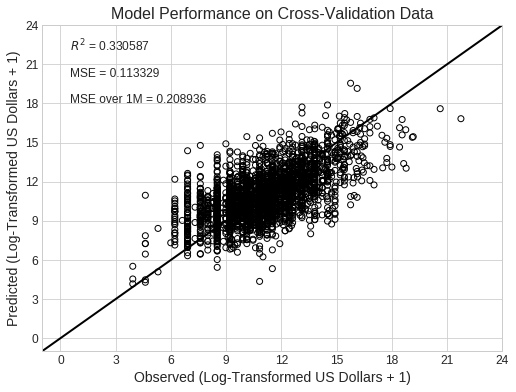

In [48]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [49]:
model.fc1.weight

Parameter containing:
 0.0713 -0.0963 -0.1611  ...  -0.2348 -0.1745  0.1636
-0.1328  0.0450 -0.0168  ...   0.1359  0.2103 -0.1906
 0.0248  0.1423  0.0835  ...  -0.2958 -0.0307 -0.0942
          ...             ⋱             ...          
 0.0083  0.0077 -0.1663  ...  -0.1529 -0.1583 -0.0227
 0.0690 -0.0663 -0.2600  ...  -0.2026  0.0271 -0.1362
-0.1461  0.1025 -0.0299  ...   0.0248  0.1047 -0.0580
[torch.FloatTensor of size 100x34]

### 4.3 Store Predictions

In [50]:
temp_df = convert_pred_to_df(cv_predictors_Tensor, 20, 4, 'cv')
stored_cv_pred_df = stored_cv_pred_df.append(temp_df, ignore_index = True)

temp_df = convert_pred_to_df(test_predictors_Tensor, 20, 4, 'test')
stored_test_pred_df = stored_test_pred_df.append(temp_df, ignore_index = True)

## 5. 10% Dropout

In [51]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 100)
        self.fc2 = torch.nn.Linear(100, 100)
        self.fc3 = torch.nn.Linear(100, 1)
        
    def forward(self, x):
        x = torch.nn.functional.dropout(x, p = 0.10)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, p = 0.10)
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.dropout(x, p = 0.10)
        x = self.fc3(x)
        return(x)


# Make it
model = Net()

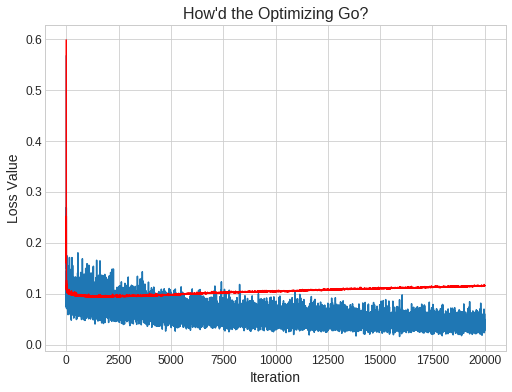

In [52]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

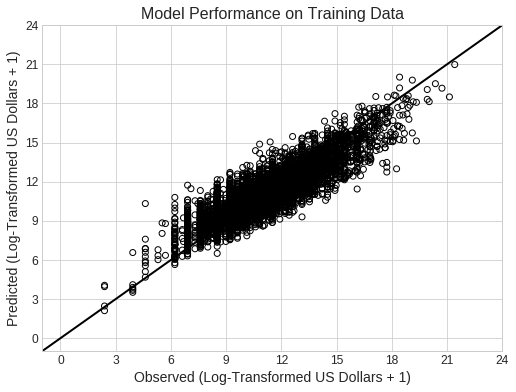

In [53]:
plot_train_perf(predictors_Tensor, outcome_Tensor)

### 5.1 Performance Metrics

In [54]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)

MSE_over_1mil = compute_MSE_over_1mil(cv_predictors_Tensor, cv_outcome_Tensor)

R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)

temp_df = save_metrics(Number_of_Parameters, R_squared, MSE, MSE_over_1mil, 20, 5)
metrics_df = metrics_df.append(temp_df, ignore_index = True)

### 5.2 Performance Visualization

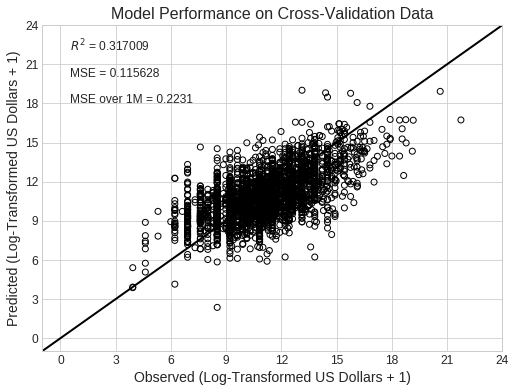

In [55]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [56]:
model.fc1.weight

Parameter containing:
-0.1642 -0.0405  0.2243  ...   0.1611  0.1697  0.0193
 0.1211  0.0992 -0.0779  ...  -0.1774 -0.0126  0.0552
-0.1416 -0.0523 -0.0258  ...   0.1938 -0.1105  0.1643
          ...             ⋱             ...          
 0.0445 -0.0699 -0.0854  ...   0.1922  0.1653  0.1909
-0.0681  0.2037  0.2226  ...   0.2092 -0.0520 -0.1507
 0.1267  0.0953 -0.0741  ...  -0.2491  0.0079 -0.0367
[torch.FloatTensor of size 100x34]

### 5.3 Store Predictions

In [57]:
temp_df = convert_pred_to_df(cv_predictors_Tensor, 20, 5, 'cv')
stored_cv_pred_df = stored_cv_pred_df.append(temp_df, ignore_index = True)

temp_df = convert_pred_to_df(test_predictors_Tensor, 20, 5, 'test')
stored_test_pred_df = stored_test_pred_df.append(temp_df, ignore_index = True)

## 6. 5% Dropout

In [58]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(34, 100)
        self.fc2 = torch.nn.Linear(100, 100)
        self.fc3 = torch.nn.Linear(100, 1)
        
    def forward(self, x):
        x = torch.nn.functional.dropout(x, p = 0.05)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, p = 0.05)
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.dropout(x, p = 0.05)
        x = self.fc3(x)
        return(x)


# Make it
model = Net()

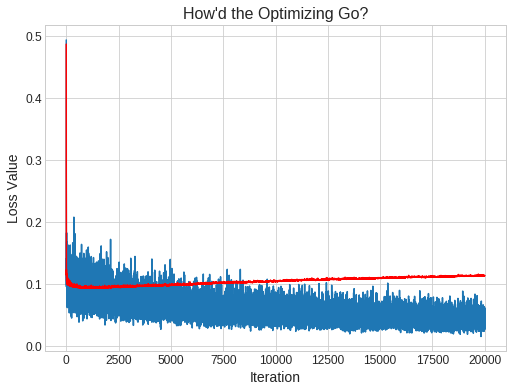

In [59]:
train_neural_net(model, outcome_Tensor, predictors_Tensor,
                 cv_outcome_Tensor, cv_predictors_Tensor)

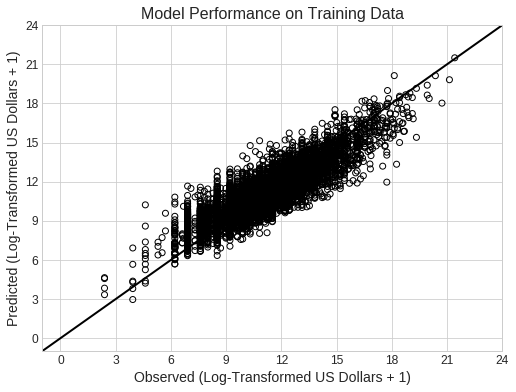

In [60]:
plot_train_perf(predictors_Tensor, outcome_Tensor)

### 6.1 Performance Metrics

In [61]:
MSE = compute_MSE(cv_predictors_Tensor, cv_outcome_Tensor)

MSE_over_1mil = compute_MSE_over_1mil(cv_predictors_Tensor, cv_outcome_Tensor)

R_squared = compute_R_squared(cv_predictors_Tensor, cv_outcome_Tensor)

temp_df = save_metrics(Number_of_Parameters, R_squared, MSE, MSE_over_1mil, 20, 6)
metrics_df = metrics_df.append(temp_df, ignore_index = True)

### 6.2 Performance Visualization

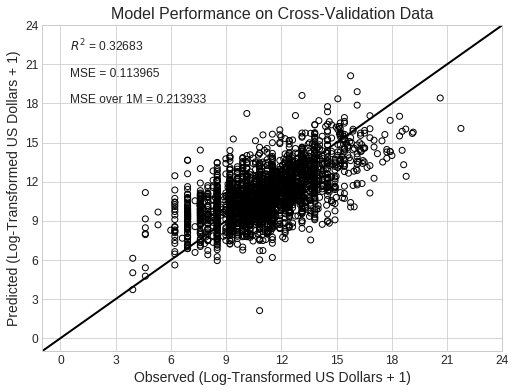

In [62]:
plot_cross_valid_perf(cv_predictors_Tensor, cv_outcome_Tensor)

In [63]:
model.fc1.weight

Parameter containing:
-0.0419 -0.1104 -0.0449  ...  -0.0014 -0.1597  0.0643
-0.1833  0.0275  0.1045  ...   0.0223 -0.1275  0.2651
-0.0991  0.0197 -0.1418  ...  -0.0559  0.0467  0.0602
          ...             ⋱             ...          
-0.0028  0.2241  0.0146  ...  -0.1183  0.0607  0.1066
-0.0801 -0.0839 -0.0022  ...   0.0586 -0.2499 -0.0068
-0.1264  0.0625 -0.0791  ...  -0.0115 -0.1219  0.0202
[torch.FloatTensor of size 100x34]

### 6.3 Store Predictions

In [64]:
temp_df = convert_pred_to_df(cv_predictors_Tensor, 20, 6, 'cv')
stored_cv_pred_df = stored_cv_pred_df.append(temp_df, ignore_index = True)

temp_df = convert_pred_to_df(test_predictors_Tensor, 20, 6, 'test')
stored_test_pred_df = stored_test_pred_df.append(temp_df, ignore_index = True)

### Take a look at what we're saving

In [65]:
stored_cv_pred_df.head()

,predicted_values,notebook_number,model_number,data_set,true_values
0,0.581275,20,1,cv,0.153220
1,0.581799,20,1,cv,0.653971
2,-0.106707,20,1,cv,0.087277
3,0.784068,20,1,cv,0.281381
4,0.756691,20,1,cv,0.559508


In [66]:
stored_test_pred_df.head()

,predicted_values,notebook_number,model_number,data_set,true_values
0,0.444135,20,1,test,0.153220
1,1.318864,20,1,test,0.653971
2,0.195352,20,1,test,0.087277
3,0.605487,20,1,test,0.281381
4,0.500295,20,1,test,0.559508


In [67]:
metrics_df

,Number of Parameters,R-squared,Mean Squared Error,Mean Squared Error Over 1M,notebook_id,model_id
0,13701,0.343789,0.111094,0.199585,20,1
1,13701,0.327100,0.113919,0.212277,20,2
2,13701,0.330540,0.113337,0.224495,20,3
3,13701,0.330587,0.113329,0.208936,20,4
4,13701,0.317009,0.115628,0.223100,20,5
5,13701,0.326830,0.113965,0.213933,20,6


In [68]:
# Save the stored predictions and outcomes as a .csv
stored_cv_pred_df.to_csv("20_cv_perf.csv")

stored_test_pred_df.to_csv("20_test_perf.csv")

metrics_df.to_csv("20_metrics.csv")